# Image Loading, EDA, and Preprocessing

In [ ]:
# Mount Google Drive in Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import dependencies
import os
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import cv2
import tensorflow as tf
import gradio as gr
import pickle

from pathlib import Path
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image

In [ ]:
# Listing Files in the Image Folder
img_folder_path = Path('/content/drive/MyDrive/Project 3 - Team 4/Images/Mpox_Skin_Images_Dataset_(MSID)')
img_path_list = list(img_folder_path.glob("*/*.png"))
print(f'Total Images = {len(img_path_list)}')

Total Images = 770


In [ ]:
# List the classes of images
classes = os.listdir(img_folder_path)
print(f'Total Classes = {len(classes)}')
print(f'Classes = {classes}')
for c in classes:
    total_images_class = list(Path(os.path.join(img_folder_path,c)).glob("*.png"))
    print(f'* {c}: {len(total_images_class)} images')

Total Classes = 4
Classes = ['Normal', 'Measles', 'Chickenpox', 'Mpox']
* Normal: 293 images
* Measles: 91 images
* Chickenpox: 107 images
* Mpox: 279 images


In [ ]:
# Create dataframe with image path list and classes as labels
images_path = [None] * len(img_path_list)
labels = [None] * len(img_path_list)

for i,img_path in enumerate(img_path_list):
    images_path[i] = img_path
    labels[i] = img_path.parent.stem

df = pd.DataFrame({'path':images_path,
                                  'label':labels})

df.head()

,path,label
0,/content/drive/MyDrive/Project 3 - Team 4/Imag...,Normal
1,/content/drive/MyDrive/Project 3 - Team 4/Imag...,Normal
2,/content/drive/MyDrive/Project 3 - Team 4/Imag...,Normal
3,/content/drive/MyDrive/Project 3 - Team 4/Imag...,Normal
4,/content/drive/MyDrive/Project 3 - Team 4/Imag...,Normal


In [ ]:
# Create function that converts an image from BGR to RGB and returns the RGB values of the image
def rgb_value(row):
  img_path = row['path']

  img_bgr = cv2.imread(str(img_path))
  img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

  return img_rgb

# Create function that converts an image from BGR to RGB and returns the mean of the RGB values for the image.
def rgb_mean(row):
  img_path = row['path']

  img_bgr = cv2.imread(str(img_path))
  img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

  return img_rgb.mean()

In [ ]:
# Apply functions to our dataframe to get new columns
df['RGB'] = df.apply(rgb_value, axis = 1)
df['RGB_Mean'] = df.apply(rgb_mean, axis = 1)
df.head()

In [ ]:
# Describe function on label and RGB_Mean
df.groupby('label')['RGB_Mean'].describe().T

label,Chickenpox,Measles,Mpox,Normal
count,107.000000,91.000000,279.000000,293.000000
mean,161.235642,134.564927,127.687267,167.201091
std,27.918873,39.026786,35.811871,43.239421
min,55.733565,54.002106,36.306122,58.931328
25%,144.644295,103.994127,102.977868,142.081938
50%,166.845723,132.721846,126.356538,172.507826
75%,177.324003,163.684222,147.728818,197.565788
max,231.898212,239.753401,222.652091,248.433282


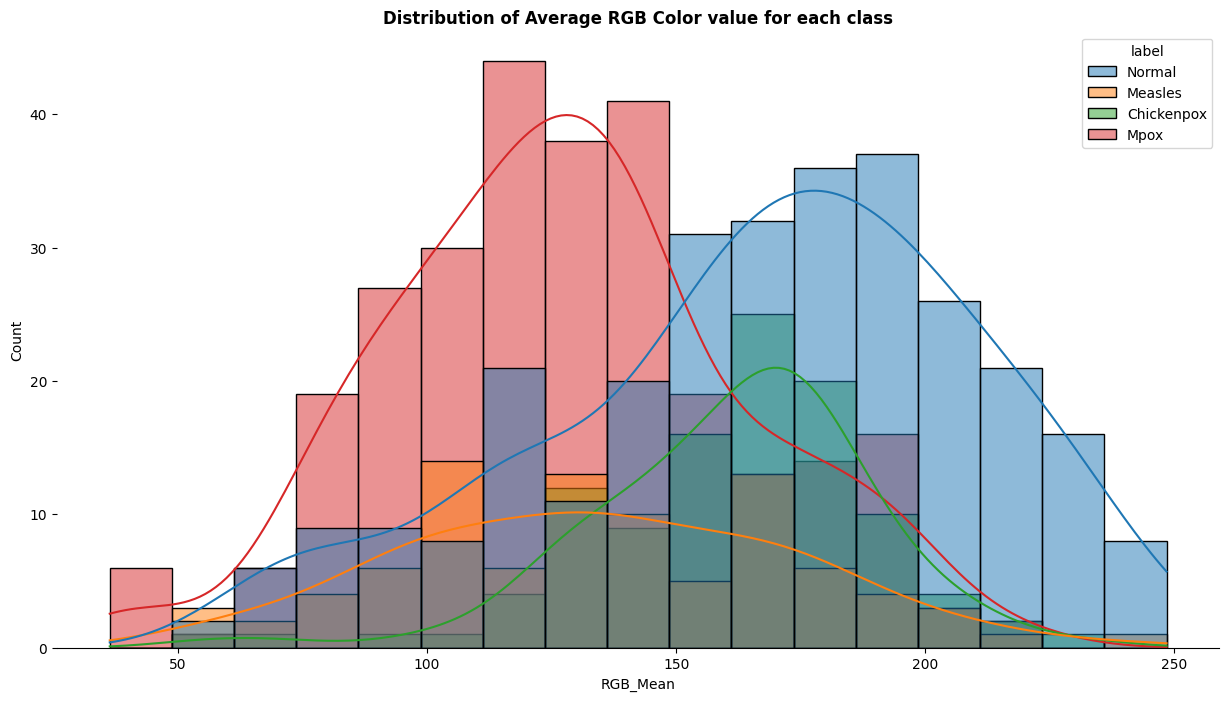

In [ ]:
#Plot the distribution of Average RGB Color value for each class
fig, ax = plt.subplots(1,1,figsize=(15,8))

sns.despine(left=True, top=True,right=True)

#sns.histplot(x='RGB_Mean',data=df.loc[df['Class'] == 'Mpox'],kde = True,ax=axs[0])
#sns.histplot(x='RGB_Mean',data=df.loc[df['Class'] == 'Chickenpox'],kde = True,ax=axs[1])
#sns.histplot(x='RGB_Mean',data=df.loc[df['Class'] == 'Measles'],kde = True,ax=axs[2])
#sns.histplot(x='RGB_Mean',data=df.loc[df['Class'] == 'Normal'],kde = True,ax=axs[3])

sns.histplot(x='RGB_Mean',data=df, hue = 'label',kde = True)

plt.title('Distribution of Average RGB Color value for each class', fontweight='bold')

plt.show()


In [ ]:
# Show data types for our dataframe
df.dtypes

,0
path,object
label,object
RGB,object
RGB_Mean,float64


In [ ]:
# Calculates and returns the average red, green, and blue (RGB) channel values of an image.
def average_r_g_b(row):
  img_path = row['path']

  img_bgr = cv2.imread(str(img_path))
  img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

  avgR = np.mean(img_rgb[:,:,0])
  avgG = np.mean(img_rgb[:,:,1])
  avgB= np.mean(img_rgb[:,:,2])

  return avgR,avgG,avgB

In [ ]:
# Apply average_r_g_b function for a new column in our dataframe
df[['R_avg','G_avg','B_avg']] = df.apply(average_r_g_b, axis = 1, result_type = 'expand')
df.head()

In [ ]:
# Define function to get the normalized pixels
def cool_stuff(row):
  img_path = row['path']

  img_bgr = cv2.imread(str(img_path))
  img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

  #print('Pixel values',img_rgb)

  normalized_pixels = img_rgb/ 255.0

  return normalized_pixels

In [ ]:
# Apply cool_stuff function for a new column in dataframe
df['Normalized_pixels_for_image'] = df.apply(cool_stuff, axis=1)
df.head()

,path,label,RGB,RGB_Mean,R_avg,G_avg,B_avg,Normalized_pixels_for_image
0,/content/drive/MyDrive/Project 3 - Team 4/Imag...,Normal,"[[[171, 148, 134], [167, 146, 132], [168, 151,...",93.586482,121.302535,92.809690,66.647222,"[[[0.6705882352941176, 0.5803921568627451, 0.5..."
1,/content/drive/MyDrive/Project 3 - Team 4/Imag...,Normal,"[[[106, 101, 104], [102, 96, 100], [98, 92, 96...",120.911339,119.781409,119.240992,123.711615,"[[[0.41568627450980394, 0.396078431372549, 0.4..."
2,/content/drive/MyDrive/Project 3 - Team 4/Imag...,Normal,"[[[217, 218, 213], [218, 219, 214], [219, 220,...",211.454228,235.778380,208.111448,190.472856,"[[[0.8509803921568627, 0.8549019607843137, 0.8..."
3,/content/drive/MyDrive/Project 3 - Team 4/Imag...,Normal,"[[[250, 250, 252], [250, 250, 252], [250, 250,...",190.413558,210.234136,185.606465,175.400072,"[[[0.9803921568627451, 0.9803921568627451, 0.9..."
4,/content/drive/MyDrive/Project 3 - Team 4/Imag...,Normal,"[[[143, 95, 69], [140, 93, 67], [143, 96, 70],...",217.230269,233.724609,213.707549,204.258650,"[[[0.5607843137254902, 0.37254901960784315, 0...."


In [ ]:
# Use LabelEncoder to encode the label column by class
le = LabelEncoder()
df['Class_encoded'] = le.fit_transform(df['label'])
df.head()

,path,label,RGB,RGB_Mean,R_avg,G_avg,B_avg,Normalized_pixels_for_image,Class_encoded
0,/content/drive/MyDrive/Project 3 - Team 4/Imag...,Normal,"[[[171, 148, 134], [167, 146, 132], [168, 151,...",93.586482,121.302535,92.809690,66.647222,"[[[0.6705882352941176, 0.5803921568627451, 0.5...",3
1,/content/drive/MyDrive/Project 3 - Team 4/Imag...,Normal,"[[[106, 101, 104], [102, 96, 100], [98, 92, 96...",120.911339,119.781409,119.240992,123.711615,"[[[0.41568627450980394, 0.396078431372549, 0.4...",3
2,/content/drive/MyDrive/Project 3 - Team 4/Imag...,Normal,"[[[217, 218, 213], [218, 219, 214], [219, 220,...",211.454228,235.778380,208.111448,190.472856,"[[[0.8509803921568627, 0.8549019607843137, 0.8...",3
3,/content/drive/MyDrive/Project 3 - Team 4/Imag...,Normal,"[[[250, 250, 252], [250, 250, 252], [250, 250,...",190.413558,210.234136,185.606465,175.400072,"[[[0.9803921568627451, 0.9803921568627451, 0.9...",3
4,/content/drive/MyDrive/Project 3 - Team 4/Imag...,Normal,"[[[143, 95, 69], [140, 93, 67], [143, 96, 70],...",217.230269,233.724609,213.707549,204.258650,"[[[0.5607843137254902, 0.37254901960784315, 0....",3


In [ ]:
# Show the labels with their encoded values
df.groupby('label')['Class_encoded'].unique()

,Class_encoded
label,
Chickenpox,[0]
Measles,[1]
Mpox,[2]
Normal,[3]


In [ ]:
# Open a new file named 'img.pkl' with write permission and use pickle to dump the DataFrame into the file - (Uncomment lines below to save again)
#with open('/content/drive/MyDrive/Project 3 - Team 4/Images/imgs.pkl', 'wb') as file:
    #pickle.dump(df, file)

# Model Development (CNN) and Metrics

In [ ]:
# Load the images from the pkl file
with open('/content/drive/MyDrive/Project 3 - Team 4/Images/imgs.pkl', 'rb') as file:
    df = pickle.load(file)

In [ ]:
# Split the dataset into train and test sets
X = df['Normalized_pixels_for_image']
y = df['Class_encoded']



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Convert the Series of images to a NumPy array
X_train = np.stack(X_train.values)
X_test = np.stack(X_test.values)

# Ensure the labels are NumPy arrays as well
y_train = np.array(y_train)
y_test = np.array(y_test)

# Print the shapes of the resulting arrays
print(X_train.shape)  # Should be (num_samples, 224, 224, 3)
print(X_test.shape)   # Should be (num_samples, 224, 224, 3)
print(y_train.shape)  # Should be (num_samples,)
print(y_test.shape)   # Should be (num_samples,)

(616, 224, 224, 3)
(154, 224, 224, 3)
(616,)
(154,)


In [ ]:
# Define a CNN model; make sure to use the correct values for input shape! 224x224
model = keras.Sequential([
    layers.InputLayer((224, 224, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(4, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
batch_size = 32
epochs = 10
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=epochs
)

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.3527 - loss: 23.6480 - val_accuracy: 0.3961 - val_loss: 2.8832
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.4444 - loss: 1.8623 - val_accuracy: 0.5584 - val_loss: 1.1624
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.5649 - loss: 1.0577 - val_accuracy: 0.5844 - val_loss: 1.1834
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.6112 - loss: 0.9599 - val_accuracy: 0.5260 - val_loss: 1.2733
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.6703 - loss: 0.8501 - val_accuracy: 0.5974 - val_loss: 1.0657
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.6926 - loss: 0.7601 - val_accuracy: 0.6429 - val_loss: 1.0577
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.7795 - loss: 0.6696 - val_accuracy: 0.6364 - val_loss: 1.0531
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.8168 - loss: 0.5779 - val_accuracy: 0.6494 - val_loss

In [ ]:
#Get accuracy metrics
metrics = model.evaluate(X_test, y_test)
print(f'Loss: {metrics[0]}')
print(f'Accuracy: {metrics[1]}')

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 638ms/step - accuracy: 0.6201 - loss: 1.3075
Loss: 1.2891514301300049
Accuracy: 0.6428571343421936


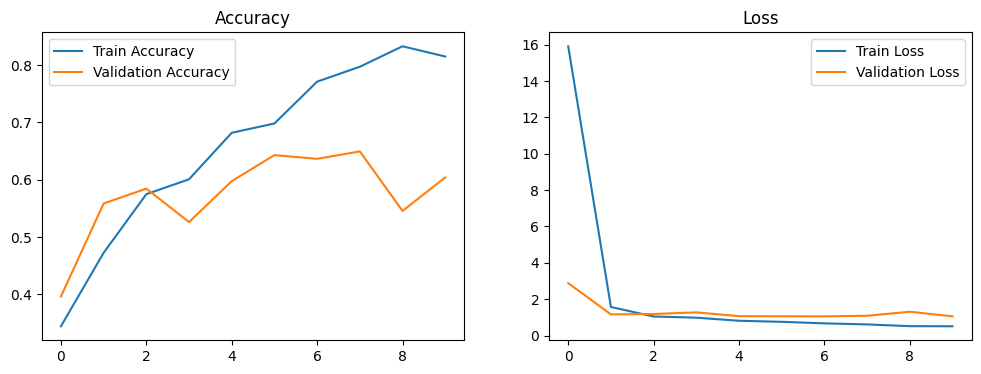

In [ ]:
# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()

In [ ]:
# Save the model - Uncomment lines below to save model again
#with open('/content/drive/MyDrive/Project 3 - Team 4/Model/modelv2.pkl', 'wb') as f:
    #pickle.dump(model, f)

In [ ]:
# Load the model
with open('/content/drive/MyDrive/Project 3 - Team 4/Model/modelv2.pkl', 'rb') as f:
    model = pickle.load(f)

# Creating the Gradio Interface

In [ ]:
import os

# Check if the file exists and its size
file_path = '/content/drive/MyDrive/Project 3 - Team 4/Model/modelv2.pkl'
if os.path.exists(file_path):
    file_size = os.path.getsize(file_path)
    print(f"File exists and its size is: {file_size} bytes")
    if file_size == 0:
        print("WARNING: The file is empty!")
else:
    print("ERROR: The file does not exist!")

File exists and its size is: 302840561 bytes


In [ ]:
#!pip install gradio
import gradio as gr
import pickle
from skimage.transform import resize
import numpy as np
# Load the model from the pickle file
with open('/content/drive/MyDrive/Project 3 - Team 4/Model/modelv2.pkl', 'rb') as file:
    model = pickle.load(file)
# Define the prediction function
# def predict(image):
#     # Resize the image to 224x224 pixels (example)
#     processed_image = resize(image, (224, 224), anti_aliasing=True)
#     # Flatten or reshape as needed by the model
#     #processed_image = processed_image.flatten().reshape(1, -1)
#     # Predict using the loaded model
#     prediction = model.predict(processed_image)
#     return f"Prediction: {prediction[0]}"
def predict(image):
    # Resize the image to 224x224 pixels with 3 color channels (for RGB)
    processed_image = resize(image, (224, 224), anti_aliasing=True)
    # If the image is grayscale, convert it to RGB by stacking the same channel 3 times
    if processed_image.shape[-1] != 3:
        processed_image = np.stack((processed_image,) * 3, axis=-1)
    # Add a batch dimension (1, 224, 224, 3)
    processed_image = np.expand_dims(processed_image, axis=0)
    # Ensure the image is in the correct data type (float32)
    processed_image = processed_image.astype(np.float32)
    # Make prediction using the loaded model
    prediction = model.predict(processed_image)

    # Convert the predictions to class indices
    predicted_classes = np.argmax(prediction, axis=1)

    # Convert class indices back to original labels
    predicted_labels = le.inverse_transform(predicted_classes)
    true_labels = le.inverse_transform(y_test)

    return f"Prediction: {predicted_labels} with predictived value of {prediction[0]}"
# Create the Gradio interface

input_component = gr.Image(label="Upload Image")
output_component = gr.Textbox(label="Prediction")
interface = gr.Interface(fn=predict, inputs=input_component, outputs=output_component,title="Mpox and Other Skin Condition Detection Tool (Not intended for medical use)", description= 'Developed by the Viral Visionaries')
# Launch the interface
interface.launch(show_error=True, share = True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://47ce969bae33afa4ab.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


# Testing an alternative model (ResNet50)

In [ ]:
# Load a pre-trained ResNet50 model, excluding the top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers (optional if you want to fine-tune)
base_model.trainable = False

# Add custom layers on top
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Reduces the feature maps to a single vector
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Adds regularization
    layers.Dense(4, activation='softmax')  # Use 'softmax' for multi-class; use 'sigmoid' for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
batch_size = 32
epochs = 10
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=epochs,
    batch_size=batch_size
)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 157s 8s/step - accuracy: 0.3304 - loss: 1.5384 - val_accuracy: 0.4026 - val_loss: 1.2546
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 145s 7s/step - accuracy: 0.4298 - loss: 1.2797 - val_accuracy: 0.5130 - val_loss: 1.2167
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 202s 7s/step - accuracy: 0.4352 - loss: 1.2611 - val_accuracy: 0.5260 - val_loss: 1.2011
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 145s 7s/step - accuracy: 0.4890 - loss: 1.2239 - val_accuracy: 0.5000 - val_loss: 1.2101
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 202s 7s/step - accuracy: 0.4531 - loss: 1.2298 - val_accuracy: 0.4545 - val_loss: 1.2168
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 144s 7s/step - accuracy: 0.4855 - loss: 1.2174 - val_accuracy: 0.5000 - val_loss: 1.1950
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 158s 8s/step - accuracy: 0.4633 - loss: 1.2056 - val_accuracy: 0.5325 - val_loss: 1.1796
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 201s 8s/step - accuracy: 0.4897 - loss: 1.2267 - val_accuracy: 0.4870 - v